### TODO:

- [ ] make this into a script
- [ ] don't use a new `lm` plot function

In [1]:
import logging
import warnings
from os.path import join

import matplotlib
import matplotlib.pyplot as plt
import myfuncs as my
import numpy as np
import pandas as pd
import pymc3 as pm

matplotlib = my.utilities.set_mpl_defaults(matplotlib)

warnings.filterwarnings("ignore")

logger = logging.getLogger("pymc3")
logger.setLevel(logging.ERROR)

RESULTS_DIR = join("..", "results")
OUTPUT_DIR = join("..", "figures")

sample_kwargs = {"cores": 1, "random_seed": 4, "progressbar": False}

In [2]:
# Read estimates file
recovery_results = pd.read_csv(
    join("..", "results", "S_recoveries", "estimates", "estimates_de1.csv")
)

In [3]:
recovery_results = recovery_results.rename({"model": "model_rec"}, axis=1)
# Recover generating model
recovery_results["model_gen"] = (
    recovery_results["subject"].str.split("-").str[1:].str.join("-")
)

# Parameter recovery

In [4]:
parameters = {
    "eu": ["alpha", "beta"],
    "pt": ["alpha", "gamma", "beta"],
    "gaze-baseline-dyn": ["lam", "beta"],
    "gaze-baseline-stat": ["beta"],
    "glickman1layer": ["alpha", "gamma", "theta", "lam", "beta"],
}

limits = dict(alpha=[0, 2], beta=[0, 50], gamma=[0, 1], lam=[0, 1], theta=[0, 1])

labels = dict(
    alpha=r"$\alpha$",
    beta=r"$\beta$",
    gamma=r"$\gamma$",
    lam=r"$\lambda$",
    theta=r"$\theta$",
)

# Colours to use
palette = [
    "slategray",
    "darksalmon",
    "mediumaquamarine",
    "indianred",
    "paleturquoise",
    "lightpink",
    "tan",
    "orchid",
]

# Model labels to use in the figures
models = np.array(
    ["glickman1layer", "mdft", "eu", "pt", "gaze-baseline-stat", "gaze-baseline-dyn"]
)

model_labels = {
    "glickman1layer": "GLA",
    "mdft": "MDFT",
    "eu": "EU",
    "pt": "PT",
    "gaze-baseline-stat": "GB$_{stat}$",
    "gaze-baseline-dyn": "GB$_{dyn}$",
}

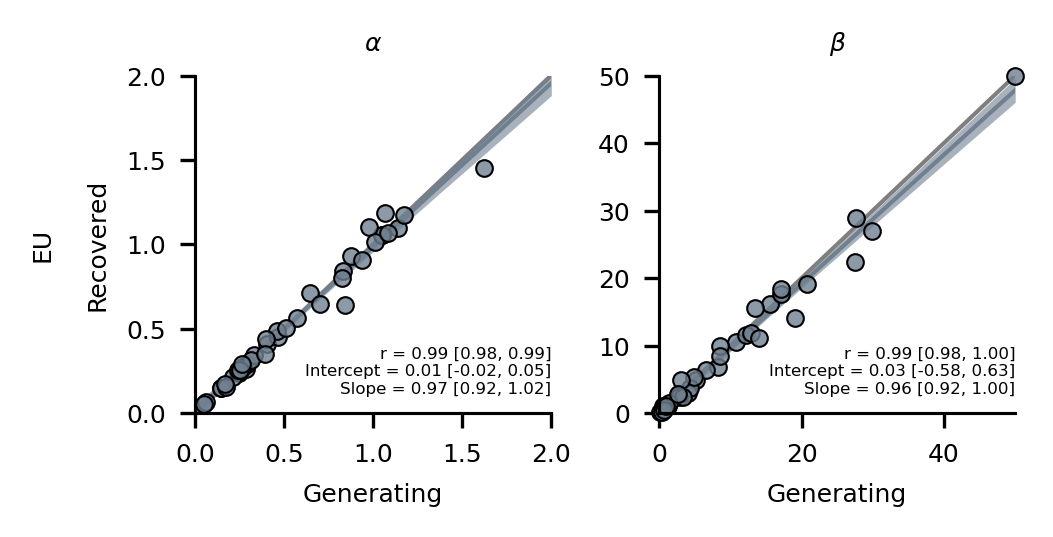

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


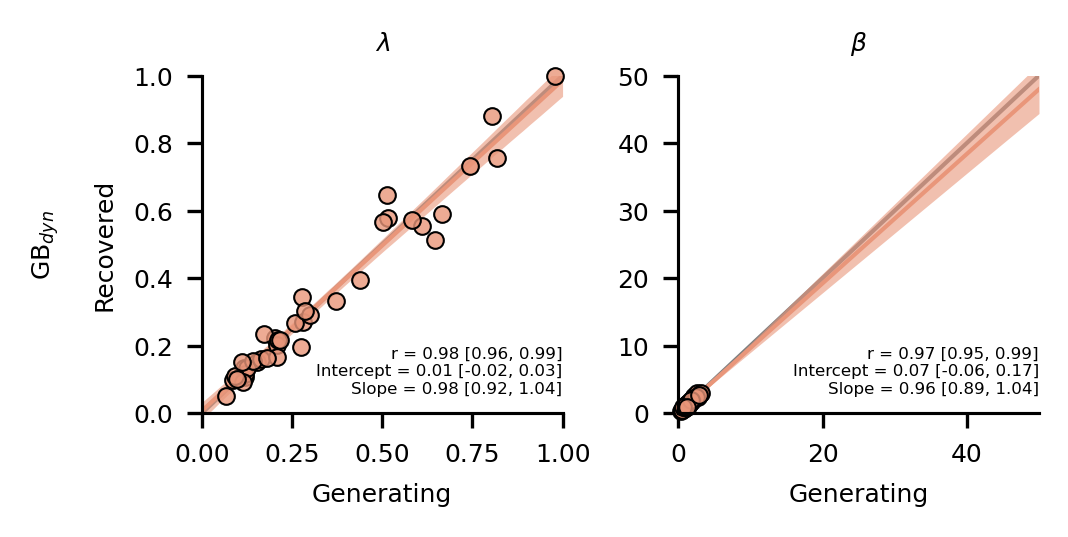

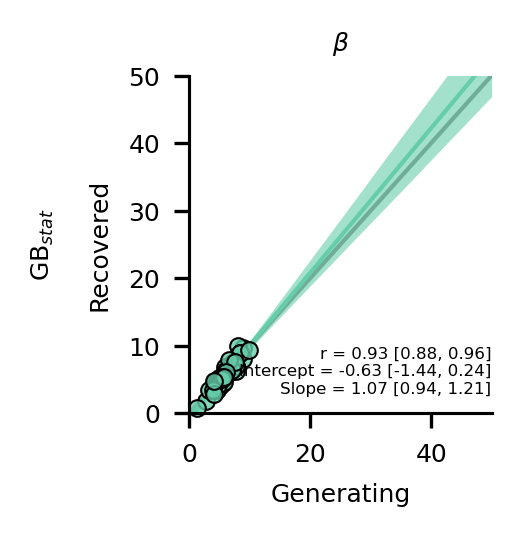

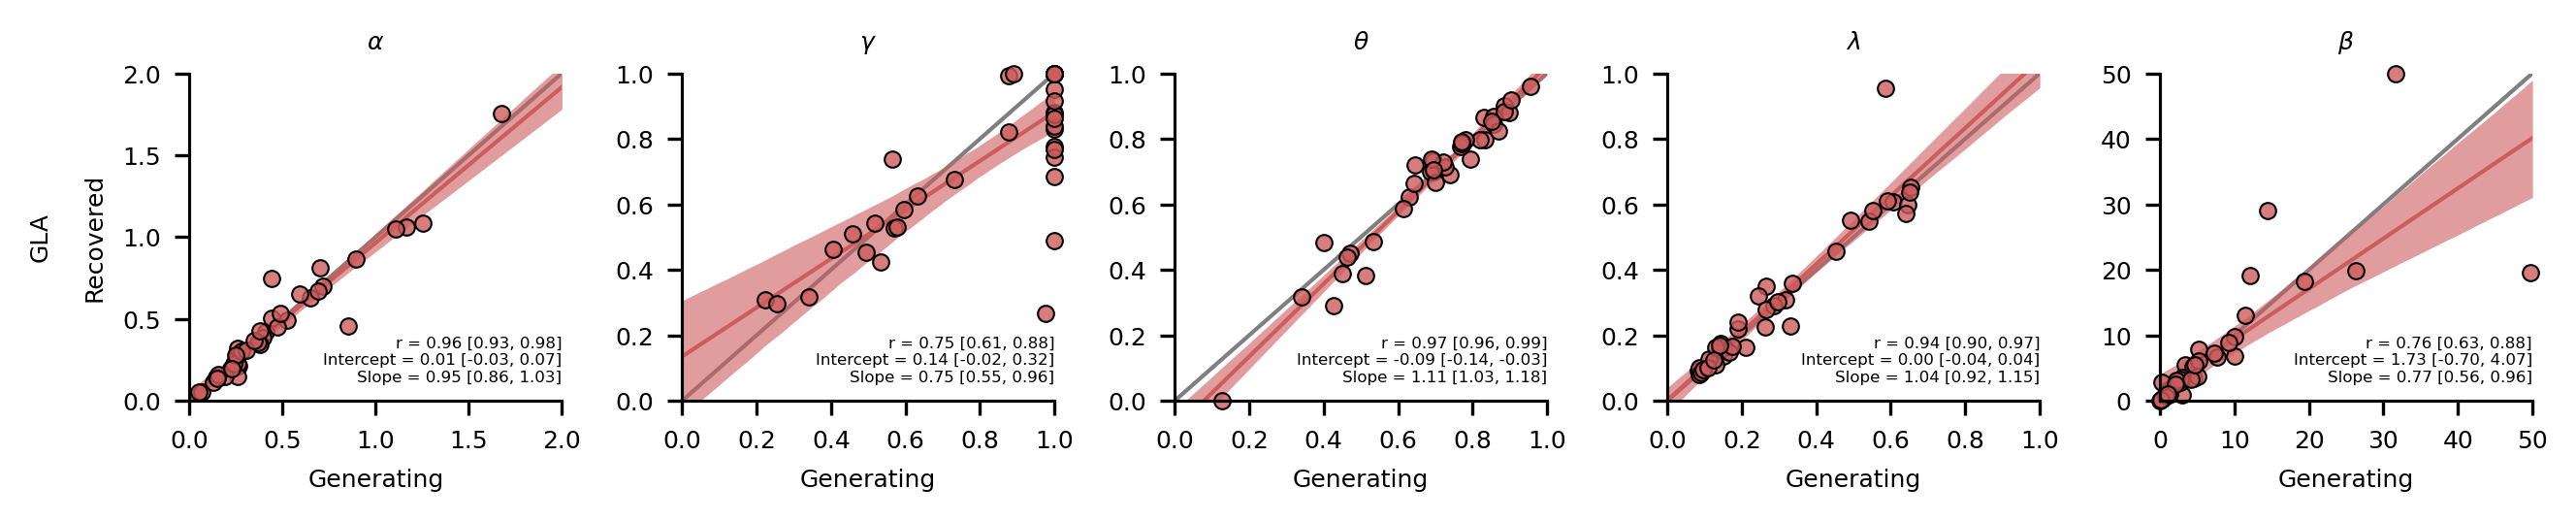

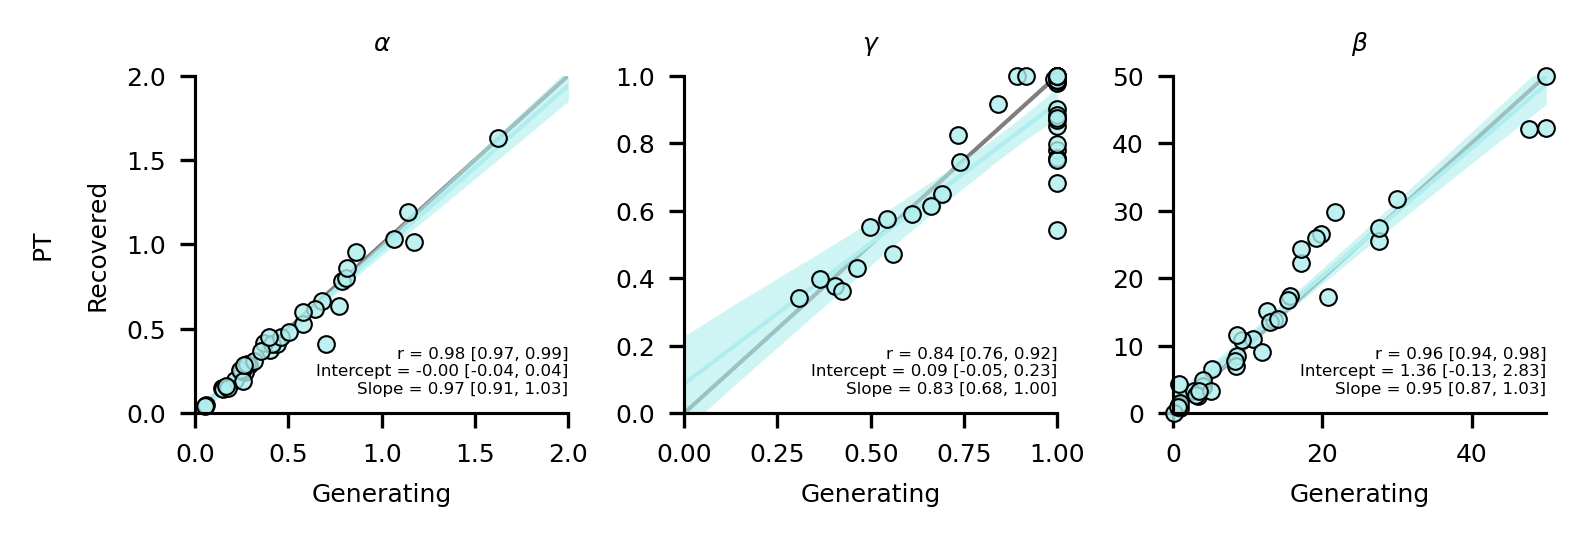

In [5]:
panel_width = 4.5
panel_height = 4.5

for m, model in enumerate(recovery_results["model_gen"].unique()):
    recovery_m = recovery_results.loc[
        (recovery_results["model_gen"] == model)
        & (recovery_results["model_rec"] == model)
    ]
    n_parameters = len(parameters[model])
    fig, axs = plt.subplots(
        1,
        n_parameters,
        figsize=my.utilities.cm2inch(n_parameters * panel_width, panel_height),
        dpi=300,
    )
    if n_parameters == 1:
        axs = np.array([axs])
    for p, parameter in enumerate(parameters[model]):
        gen = recovery_m[parameter + "_gen"]
        rec = recovery_m[parameter]
        axs[p], glm_data, corr_data = my.plots.lm(
            x=gen,
            y=rec,
            sample_kwargs=sample_kwargs,
            ax=axs[p],
            scatter_color=palette[m],
            scatter_kws=dict(clip_on=False),
            line_color=palette[m],
            xrange=limits[parameter],
        )
        axs[p].set_title(labels[parameter])
        axs[p].set_xlabel("Generating")
        axs[p].set_xlim(*limits[parameter])
        axs[p].set_ylim(*limits[parameter])
        axs[p].plot(
            limits[parameter], limits[parameter], color="k", alpha=0.5, zorder=-1
        )
        if p == 0:
            axs[p].set_ylabel(f"{model_labels[model]}\n\nRecovered")
    plt.tight_layout()
    plt.savefig(
        join("..", "figures", f"S_parameter-recovery_{model}.pdf"), bbox_inches="tight"
    )
    plt.show()

# Model recovery

For model recovery, we need to perform one Bayesian Model Selection (BMS) analysis for each generating model.

In [6]:
models = recovery_results["model_gen"].unique()
models

array(['eu', 'gaze-baseline-dyn', 'gaze-baseline-stat', 'glickman1layer',
       'pt'], dtype=object)

In [7]:
bms_results = {}
xp = np.zeros((len(models), len(models))) * np.nan
mpp = np.zeros_like(xp) * np.nan

# for each generating model:
for m, model in enumerate(models):
    bics = (
        recovery_results.loc[recovery_results["model_gen"] == model][
            ["subject", "model_gen", "model_rec", "bic"]
        ]
        .pivot_table(values="bic", columns="model_rec", index="subject")[models]
        .T.values
    )
    L = -0.5 * bics

    bms_results[model] = my.stats.bms(L, cores=1)
    xp[m, :] = bms_results[model]["xp"]
    mpp[m, :] = bms_results[model]["r"]

There were 541 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1392 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 92 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


There were 115 divergences after tuning. Increase `target_accept` or reparameterize.
There were 170 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


The estimated number of effective samples is smaller than 200 for some parameters.


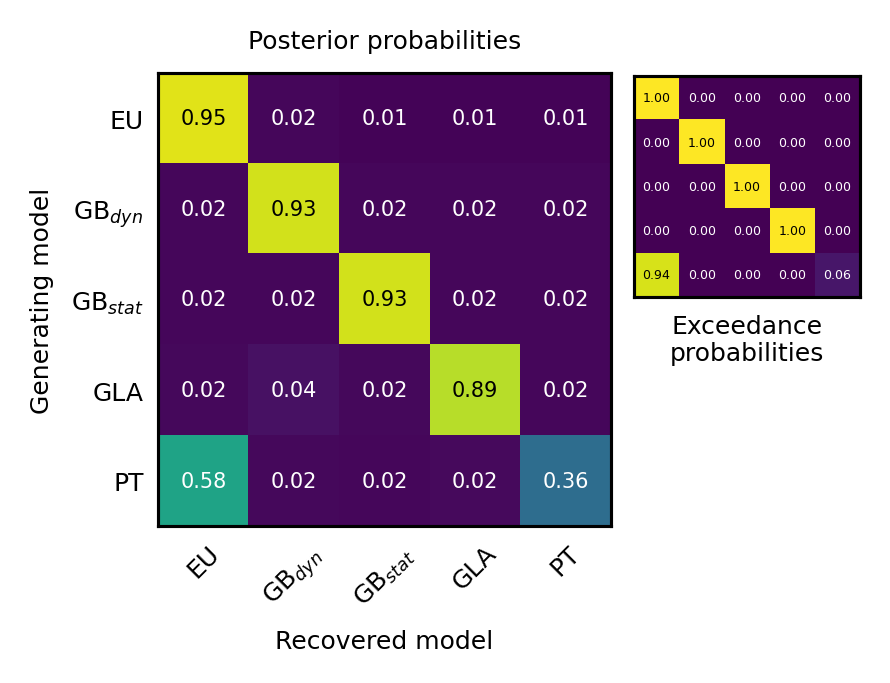

In [8]:
# Plot
ax = my.plots.model_recovery(
    mpp=mpp,
    xp=xp,
    model_labels=[model_labels[model] for model in models],
    inset_aspect=0.75,
)
plt.savefig(join("..", "figures", "S_model-recovery.pdf"), dpi=300, bbox_inches="tight")